# PROYECTO DE ANÁLISIS DE MARKOWITZ

## LIBRERÍAS

Se empieza importando las librerías a utilizar en el trabajo. Recordar que lo más probable alguna, varias o incluso todas ellas no
se encuentren previamente instaladas, por lo que se debería de comenzar con ello.

In [1]:
import json
import pandas as pd 
import numpy as np
import yfinance as yf 
import itertools
import matplotlib.pyplot as plt
import scipy.optimize as sco
import pathlib
import warnings

warnings.filterwarnings("ignore") 

## EXPLICACIÓN TEÓRICA COMBINATORIAS

La base para poder identificar cuáles son todos los portafolios posibles es la combinación de los diferentes tickers, sin que estos se repitan. Para
cumplir con este objetivo, se utilizará la función combinations de la librería itertools para saber cuáles son estas combinaciones, y la cantidad de ellas.

<img src="Imagenes/Imagen_combinatoria.png">

Para comenzar y entender el impacto de las combinatorias en la optimización de todos los portafolios, se debe comprender en primera instancia la fórmula  para el cálculo de la cantidad de combinatorias, la cuál se encuentra arriba de esta líneas. "n" simboliza la cantidad de elementos que se deben de combinar (en el caso del trabajo, la cantidad de tickers disponibles para la conformación de portafolios), y "k" la cantidad de elementos que debe de poseer cada combinación (en cuanto a portafolios, el número de acciones dentro de cada uno de ellos). Para comprender el impacto de la variabilidad de estos parámetros sobre la cantidad de combinaciones, se hicieron unas pequeñas simulaciones.

In [354]:
prueba = [i for i in range(7)]
combina = []
for i in range(1, 8):
    numero = list(itertools.combinations(prueba, i))
    combina.append(len(numero))
combina

[7, 21, 35, 35, 21, 7, 1]

In [355]:
sum(combina)

127

Como se observa, la cantidad de combinaciones cuando n y k son reducidos, son muy pocas. Aún así, se puede apreciar la ditribución cuadrática inversa que sigue la cantidad de combinaciones a medida que aumenta el valor de k, dado un valor fijo de n.

In [352]:
%%time

prueba_2 = [i for i in range(20)]
combina_2 = []
for i in range(0, 15):
    numero_2 = list(itertools.combinations(prueba_2, i))
    combina_2.append(len(numero_2))
combina_2

CPU times: total: 156 ms
Wall time: 185 ms


[1,
 20,
 190,
 1140,
 4845,
 15504,
 38760,
 77520,
 125970,
 167960,
 184756,
 167960,
 125970,
 77520,
 38760]

In [353]:
sum(combina_2)

1026876

Ahora bien, cuando los valores tanto de n como de k se incrementan, la cantidad de combinaciones crece exponencialmente, pero siempre siguiendo el formato de función cuadrática inversa que se describió en el caso anterior. Por tanto, si en lugar de utilizar el Dow Jones que está compuesto por 30 acciones, se utilizaba el S&P que está compuesto por 500, el número de combinaciones sería astronómico (sin exagerar), y el programa no acabaría nunca, impidiendo así obtener resultados para extraer conclusiones.

## DATOS

### Obtención de Tickers

El código de esta sección permite obtener un diccionario con los diferentes años como claves, y como valores una lista con los tickers que conformaron al Dow Jones en ese año correspondiente

In [37]:
URL = 'https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average'
tickers = pd.read_html(URL)[1]['Symbol'].tolist()

In [38]:
i = 2024
listado_empresas = {}
while i >= 1970:
    tickers_total = tickers.copy()

    if i <= 2023: 
        nuevos_tickets = ['AMZN']
        viejos_tickets = ['WBA']
        tickers_total = [viejos_tickets[nuevos_tickets.index(ticker)] if ticker in nuevos_tickets else ticker for ticker in tickers_total]
    if i <= 2020: 
        nuevos_tickets = ['AMGN' , 'HON' , 'CRM']
        viejos_tickets = ['UTC' , 'XOM' , 'PFE']
        tickers_total = [viejos_tickets[nuevos_tickets.index(ticker)] if ticker in nuevos_tickets else ticker for ticker in tickers_total]
    if i <= 2019: 
        nuevos_tickets = ['DOW']
        viejos_tickets = ['DD']
        tickers_total = [viejos_tickets[nuevos_tickets.index(ticker)] if ticker in nuevos_tickets else ticker for ticker in tickers_total]
    if i <= 2018: 
        nuevos_tickets = ['WBA']
        viejos_tickets = ['GE']
        tickers_total = [viejos_tickets[nuevos_tickets.index(ticker)] if ticker in nuevos_tickets else ticker for ticker in tickers_total]
    if i <= 2015:
        nuevos_tickets = ['AAPL']
        viejos_tickets = ['T']
        tickers_total = [viejos_tickets[nuevos_tickets.index(ticker)] if ticker in nuevos_tickets else ticker for ticker in tickers_total]
    if i <= 2013: 
        nuevos_tickets = ['GS', 'NKE' , 'V']
        viejos_tickets = ['BAC' , 'AA' , 'HPQ']
        tickers_total = [viejos_tickets[nuevos_tickets.index(ticker)] if ticker in nuevos_tickets else ticker for ticker in tickers_total]
    if i <= 2012:
        nuevos_tickets = ['UNH']
        viejos_tickets = ['KFT']
        tickers_total = [viejos_tickets[nuevos_tickets.index(ticker)] if ticker in nuevos_tickets else ticker for ticker in tickers_total]
    if i <= 2009: 
        nuevos_tickets = ['TRV' , 'CSCO']
        viejos_tickets = ['C' , 'MTLQQ']
        tickers_total = [viejos_tickets[nuevos_tickets.index(ticker)] if ticker in nuevos_tickets else ticker for ticker in tickers_total]
    if i <= 2008: 
        nuevos_tickets = ['CVX' , 'BAC' , 'KFT']
        viejos_tickets = ['MO' , 'HON' , 'AIG']
        tickers_total = [viejos_tickets[nuevos_tickets.index(ticker)] if ticker in nuevos_tickets else ticker for ticker in tickers_total]
    if i <= 2004: 
        nuevos_tickets = ['AIG' , 'PFE' , 'VZ']
        viejos_tickets = ['T', 'KODK' , 'IP']
        tickers_total = [viejos_tickets[nuevos_tickets.index(ticker)] if ticker in nuevos_tickets else ticker for ticker in tickers_total]
    if i <= 1999: 
        nuevos_tickets = ['MSFT' , 'INTC' , 'HD' , 'T']
        viejos_tickets = ['CVX' , 'GT' , 'UK' , 'SHLDQ']
        tickers_total = [viejos_tickets[nuevos_tickets.index(ticker)] if ticker in nuevos_tickets else ticker for ticker in tickers_total]
    if i <= 1997: 
        nuevos_tickets = ['WMT' , 'JNJ' , 'HPQ' , 'C']
        viejos_tickets = ['WX' , 'FL' , 'CVQ' , 'bs']
        tickers_total = [viejos_tickets[nuevos_tickets.index(ticker)] if ticker in nuevos_tickets else ticker for ticker in tickers_total]
    if i <= 1991: 
        nuevos_tickets = ['DIS' , 'CAT' , 'JPM']
        viejos_tickets = ['X' , 'NAV' , 'PRI']
        tickers_total = [viejos_tickets[nuevos_tickets.index(ticker)] if ticker in nuevos_tickets else ticker for ticker in tickers_total]
    if i <= 1987: 
        nuevos_tickets = ['KO' , 'BA']
        viejos_tickets = ['OI' , 'VALE']
        tickers_total = [viejos_tickets[nuevos_tickets.index(ticker)] if ticker in nuevos_tickets else ticker for ticker in tickers_total]
    if i <= 1985: 
        nuevos_tickets = ['MCD' , 'MO']
        viejos_tickets = ['GIS' , 'GBX']
        tickers_total = [viejos_tickets[nuevos_tickets.index(ticker)] if ticker in nuevos_tickets else ticker for ticker in tickers_total]
    if i <= 1982: 
        nuevos_tickets = ['AXP'] 
        viejos_tickets = ['JM'] 
        tickers_total = [viejos_tickets[nuevos_tickets.index(ticker)] if ticker in nuevos_tickets else ticker for ticker in tickers_total]
    if i <= 1979: 
        nuevos_tickets = ['MRK' , 'IBM'] 
        viejos_tickets = ['STLA' , 'JBSAY'] 
        tickers_total = [viejos_tickets[nuevos_tickets.index(ticker)] if ticker in nuevos_tickets else ticker for ticker in tickers_total]
    if i <= 1976: 
        nuevos_tickets = ['MMM'] 
        viejos_tickets = ['BP']
        tickers_total = [viejos_tickets[nuevos_tickets.index(ticker)] if ticker in nuevos_tickets else ticker for ticker in tickers_total]

    listado_empresas[f'{i}'] = tickers_total
    i -= 1 

In [41]:
#Se exporta el diccionario para almacenarlo en un archivo .json
try: 
    empresas_JSON = json.dumps(listado_empresas, indent = 4)
    empresas_todos_los_años = open("Empresas/Empresas_años.json" , "w")
    empresas_todos_los_años.write(empresas_JSON)
    empresas_todos_los_años.close()
except: 
    print("No se puede guardar el diccionario en el archivo")

In [40]:
#Se obtiene una lista con los tickers de TODAS las empresas que formaron parte del Dow Jones desde 1.970
todos_los_tickers = set()
for listados in listado_empresas: 
    todos_los_tickers = todos_los_tickers | set(listado_empresas[listados])
todos_los_tickers = list(todos_los_tickers)
len(todos_los_tickers)

65

### Datos de TODAS las empresas

Esta sección se centra en obtener los precios históricos diarios de todas las acciones que se encuentran en la lista de empresas que conformaron al Dow Jones desde 1.970

In [18]:
data_historica_acciones = yf.download(todos_los_tickers)['Adj Close']
data_historica_acciones.to_csv(r'C:/Users/silva/Desktop/Metodologia_Markowitz-Sharpe/Dataset/Datos_acciones.csv')

[*********************100%%**********************]  65 of 65 completed

7 Failed downloads:
['BS', 'KFT', 'WX', 'UTC', 'MTLQQ']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1925-08-04 -> 2024-07-11)')
['SHLDQ', 'NAV']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [20]:
data_acciones = pd.read_csv('Dataset/Datos_acciones.csv')
data_acciones.head()

,Date,AA,AAPL,AIG,AMGN,AMZN,AXP,BA,BAC,BP,...,UNH,UTC,V,VALE,VZ,WBA,WMT,WX,X,XOM
0,1962-01-02,1.503235,NaN,NaN,NaN,NaN,NaN,0.190931,NaN,0.048472,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.094137
1,1962-01-03,1.526231,NaN,NaN,NaN,NaN,NaN,0.194750,NaN,0.049136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.095535
2,1962-01-04,1.526231,NaN,NaN,NaN,NaN,NaN,0.192840,NaN,0.048251,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.095768
3,1962-01-05,1.523356,NaN,NaN,NaN,NaN,NaN,0.189022,NaN,0.046923,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.093671
4,1962-01-08,1.471619,NaN,NaN,NaN,NaN,NaN,0.189499,NaN,0.047808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.093438


In [13]:
#Se utiliza esta función para ver la cantidad de datos no nulos de cada una de las empresas, es decir, para saber cuanta info se tiene de cada una
data_acciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15697 entries, 0 to 15696
Data columns (total 66 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    15697 non-null  object 
 1   AA      15697 non-null  float64
 2   AAPL    10944 non-null  float64
 3   AIG     12952 non-null  float64
 4   AMGN    10309 non-null  float64
 5   AMZN    6792 non-null   float64
 6   AXP     13098 non-null  float64
 7   BA      15697 non-null  float64
 8   BAC     12918 non-null  float64
 9   BP      15697 non-null  float64
 10  BS      0 non-null      float64
 11  C       11941 non-null  float64
 12  CAT     15697 non-null  float64
 13  CRM     5006 non-null   float64
 14  CSCO    8623 non-null   float64
 15  CVQ     163 non-null    float64
 16  CVX     15697 non-null  float64
 17  DD      13098 non-null  float64
 18  DIS     15697 non-null  float64
 19  DOW     1296 non-null   float64
 20  FL      15697 non-null  float64
 21  GBX     7510 non-null   float64
 22

### Datos del Dow Jones

En esta sección se busca obtener la mayor cantidad de valores diarios del Dow Jones. Se obtienen desde los lugares, con el ticker DJI se obtienen los valores del propio índice, mientras que con DJIA se obtienen los valores del ETF del Dow Jones, que empezó a cotizar en el 2.022

In [2]:
dow_jones = yf.download('DJI')['Adj Close']
dow_jones.to_csv(r'C:/Users/silva/Desktop/Metodologia_Markowitz-Sharpe/Dataset/DJI.csv')

[*********************100%%**********************]  1 of 1 completed


In [4]:
DJI = pd.read_csv('Dataset/DJI.csv')
DJI.head()

,Date,Adj Close
0,1970-01-02,809.200012
1,1970-01-05,811.309998
2,1970-01-06,803.659973
3,1970-01-07,801.809998
4,1970-01-08,802.070007


In [5]:
DJI.tail(7)

,Date,Adj Close
12980,2022-02-22,33596.601562
12981,2022-02-23,33131.800781
12982,2022-02-24,33223.800781
12983,2022-02-25,34058.800781
12984,2022-02-28,33892.601562
12985,2022-03-01,33294.898438
12986,2022-03-02,33891.300781


In [6]:
#DJI['Date'] = pd.to_datetime(DJI['Date'])
#Vemos la cantidad de datos de la serie de DJI
DJI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12987 entries, 0 to 12986
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       12987 non-null  object 
 1   Adj Close  12987 non-null  float64
dtypes: float64(1), object(1)
memory usage: 203.1+ KB


In [7]:
dow_jones_2 = yf.download('DJIA')['Adj Close']
dow_jones_2.to_csv(r'C:/Users/silva/Desktop/Metodologia_Markowitz-Sharpe/Dataset/DJIA.csv')

[*********************100%%**********************]  1 of 1 completed


In [15]:
DJIA = pd.read_csv('Dataset/DJIA.csv')
DJIA.head()

,Date,Adj Close
0,2022-02-24,20.012421
1,2022-02-25,20.324968
2,2022-02-28,20.339025
3,2022-03-01,20.069469
4,2022-03-02,20.390289


In [16]:
#Vemos la cantidad de datos de la serie de DJIA
DJIA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597 entries, 0 to 596
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       597 non-null    object 
 1   Adj Close  597 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.5+ KB


### Emplame de series del Dow Jones

En esta sección se va a construir el csv con todos los datos que se poseen del Dow Jones. Para ello, se van a tener que empalmar las series de DJI y de DJIA, ya que mientras que la primera termina en el 2.022, la segunda comienza para esa fecha. Para lograrlo, se deberá de obtener un número que permita convertir los valores de una, en valores semejantes a los de la otra.

In [17]:
DJIA['Date'][0]

'2022-02-24'

In [19]:
#Se va a calcular el factor por el que hará de multiplicarse a los valores de la serie de DJIA, para que sean semejantes a los de la serie de DJI
corte = int(DJI.loc[DJI['Date'] == DJIA['Date'][0]].index[0])

numeros_empalmados = DJI[corte:].set_index('Date')
empalme = pd.concat([DJIA.set_index('Date'), numeros_empalmados], axis = 1).dropna()
empalme['factor_de_empalme'] = empalme.iloc[:, 1] / empalme.iloc[:, 0]

#Se calcula el factor de empalme
factor_empalme = empalme['factor_de_empalme'].mean()
factor_empalme

1664.6732241051843

In [12]:
DJIA['Adj Close'] = DJIA['Adj Close'].copy() * factor_empalme
DJIA.head()

,Date,Adj Close
0,2022-02-24,33314.140813
1,2022-02-25,33834.430573
2,2022-02-28,33857.831150
3,2022-03-01,33409.108419
4,2022-03-02,33943.168641


In [13]:
ultimo_dato = DJI.iloc[-1][0]
corte_ultimo_dato = int(DJIA.loc[DJIA['Date'] == ultimo_dato].index[0])
DJIA = DJIA.copy()[corte_ultimo_dato+1:]
DJIA.head()

,Date,Adj Close
5,2022-03-03,33839.929867
6,2022-03-04,33757.351549
7,2022-03-07,33106.291618
8,2022-03-08,32945.246752
9,2022-03-09,33323.761403


In [14]:
empalme = pd.concat([DJI, DJIA], axis = 0).set_index('Date')
empalme.to_csv(r'C:/Users/silva/Desktop/Metodologia_Markowitz-Sharpe/Dataset/DOW_JONES_EMPALMADO.csv')

### Datos de bonos del tesoro

En esta sección se analiza la info que se consiguio sobre los rendimientos de los bonos del tesoro para distintos vencimientos

In [32]:
bonos_2 = pd.read_csv('Dataset/us_treasury_yields_daily.csv')
bonos_2.rename(columns = {'date': 'Date'}, inplace = True)
bonos_2.set_index('Date' , inplace = True)
bonos_2 = bonos_2 / 100

In [55]:
#Se muestra la cantidad de información que se tienen de cada uno de los bonos
bonos_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16289 entries, 1962-01-02 to 2024-06-07
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   US1M    5717 non-null   float64
 1   US3M    10693 non-null  float64
 2   US6M    10693 non-null  float64
 3   US1Y    15595 non-null  float64
 4   US2Y    12003 non-null  float64
 5   US3Y    15595 non-null  float64
 6   US5Y    15595 non-null  float64
 7   US7Y    13725 non-null  float64
 8   US10Y   15595 non-null  float64
 9   US20Y   13906 non-null  float64
 10  US30Y   11825 non-null  float64
dtypes: float64(11)
memory usage: 1.5+ MB


In [56]:
#Se muestran los distintos bonos para los que se tiene data, más que nada para saber los vencimientos que se poseen
bonos_2.columns

Index(['US1M', 'US3M', 'US6M', 'US1Y', 'US2Y', 'US3Y', 'US5Y', 'US7Y', 'US10Y',
       'US20Y', 'US30Y'],
      dtype='object')

In [35]:
bonos_2.to_csv(r'C:/Users/silva/Desktop/Metodologia_Markowitz-Sharpe/Dataset/rendimientos_bonos.csv')

## FUNCIONES

### Solicitud de información

Estas funciones tienen el fin de poder obtener la información primaria necesaria para poder realizar tanto la optimización, como la evaluación y comparación del portafolio óptimo con el índice Dow Jones

In [42]:
def separar_fecha(fecha):
    '''Esta función busca separar las fechas en sus partes: año, mes y día
    Args: la fecha que se quiere dividir
    Retorna los valores de año, mes y día respectivamente, y en formato entero'''
    partes_fecha = fecha.split("-")

    return int(partes_fecha[0]) , int(partes_fecha[1]) , int(partes_fecha[2])

def importador():
    '''Esta  función sirve para importar los datos necesarios para la optimización
    Retorna los dataframes con los datos del Dow Jones, de los precios de las acciones que lo han compuesto, y del rendimiento de los bonos'''
    
    dj = pd.read_csv('Dataset/DOW_JONES_EMPALMADO.csv')
    acciones = pd.read_csv('Dataset/Datos_acciones.csv')
    bonos = pd.read_csv('Dataset/rendimientos_bonos.csv')

    return dj , acciones , bonos

def importador_diccionario_empresas(): 
    '''Esta función permite importa las listas con las empresas que compusieorn el indice año a año
    Retorna un diccionario que posee como clave los años desde 1970, y como valor una lista con los tickers de las empresas que estuvieron en el DJ'''
    
    try:
        listado_empresas = open("Empresas/Empresas_años.json" , "r")
        empresas = listado_empresas.read() 
        listado_empresas.close()
        empresas = json.loads(empresas)
    except: 
        print("No se pudo importar el archivo")

    return empresas

def restriccion_temporal(acciones, dow_jones):
    '''La función busca imponer los límites a las fechas que puede poner el usuario para el análisis
    Args: dataframe con los datos de las acciones, df con los datos del DJ
    Retorna las fechas que imponen límites, de inicio y de finalización, a los periodos en los que se pueden hacer los análisis'''
    
    inicio_acciones = list(acciones['Date'])[0]
    inicio_dow_jones = list(dow_jones['Date'])[0]
    if inicio_acciones > inicio_dow_jones:
        limite_inicial = inicio_acciones
    else:
        limite_inicial = inicio_dow_jones

    fin_acciones = list(acciones['Date'])[-1]
    fin_dow_jones = list(dow_jones['Date'])[-1]
    if fin_acciones > fin_dow_jones:
        limite_final = fin_acciones
    else:
        limite_final = fin_dow_jones
    
    return limite_inicial, limite_final

def validacion_mes():
    '''Permite validar si el valor del mes tiene sentido
    Retorna, en caso de que el valor se encuentre entre 1 y 12, el valor del mes ingresado'''
    
    while True:
        try: 
            mes = int(input("Ingrese el mes correspondiente: "))
            if mes < 1 or mes > 12:
                print("El número ingresado no corresponde con níngun mes")
            else:
                break
        except ValueError:
            print("El valor ingresado no es un número")
    return mes
    
def validacion_dia():
    '''Permite validar si el valor del dia tiene sentido
    Retorna, en caso de que el valor se encuentre entre 1 y 31, el valor del dia ingresado'''
    while True:
        try: 
            dia = int(input("Ingrese el dia correspondiente: "))
            if dia < 1 or dia > 31:
                print("Ningún mes del año tiene la cantidad de días ingresada")
            else:
                break
        except ValueError:
            print("El valor ingresado no es un número")
    return dia
    
def periodo_de_analisis(inicio_lim, fin_lim):
    '''Esta funcion es para ingresar los valores por teclado los valores para la fecha de inciio y de la finalización del periodo de análisis
    Args: fecha de límite inicial, fecha de limite final
    Retorna las fechas de inciio y de la finalización del periodo de analisis'''
    while True:
        try:
            año = int(input("Ingrese el año de comienzo del análisis: "))
            mes = validacion_mes()
            dia = validacion_dia()
            comienzo = f'{año}-{mes}-{dia}'
            if comienzo < inicio_lim:
                print("No existen valores tan hacia atrás en el tiempo")
            else:
                break
        except ValueError:
            print("El valor ingresado no es un número")
    while True:
        try:            
            año_fin = int(input("Ingrese el año de finalización del análisis: "))
            mes_fin = validacion_mes()
            dia_fin = validacion_dia()
            final = f'{año_fin}-{mes_fin}-{dia_fin}'
            if final > fin_lim:
                print("No existen valores tan cercanos en el tiempo")
            elif final < comienzo:
                print("El final del periodo de análsis no puede ser anterior al inicio")
            else:
                break
        except ValueError:
            print("El valor ingresado no es un número")
    return comienzo, final

def periodo_evaluacion(ini_analisis, lim_analisis):
    '''Similar que la función anterior, pero para el periodo de evaluación
    Args: fecha de finalización del periodo de análisis, y fecha de limite final para las solicitudes
    Retorna las fechas de inicio y de finalización para el periodo de evaluación'''
    while True:
        try:
            año_fin = int(input("Ingrese el año de finalización de la evaluación: "))
            mes_fin = validacion_mes()
            dia_fin = validacion_dia()
            final = f'{año_fin}-{mes_fin}-{dia_fin}'
            if final < ini_analisis:
                print("La evaluación no puede iniciar antes que la finalización del análisis")
            elif final > lim_analisis:
                print("No existen datos posteriormente a esta fecha")
            else: 
                break 
        except ValueError:
            print("El valor ingresado no es un número")
    return ini_analisis, final

### Tratamiento de los Datos

Estas funciones trabajan la información primaria para poder obtener los dataframes finales que serán usados para realizar la optimización, y que posteriormente serán acomodados para contruir los gráficos. Entre las transformaciones hallamos el recorte temporal de los dataframes, el rellenado de los valores nulos, un filtrado de aquellas que no llegan a un mínimo de datos no nulos, entre otras.

In [43]:
def seleccion_tickers(tickers_año_a_año, fecha_ini, fecha_fn): 
    '''La función pemite obtener los tickers de las empresas que parmanecieron conformando al índice durante todo el periodo de análisis
    Args: diccionario con los tickers de las empresas por año, fecha inicio del analisis, fecha finalizacion del analisis
    Retorna una lista con los tickers de las empresas que se encuentran tanto al inicio como al final del analisis'''
    
    año_ini = separar_fecha(fecha_ini)[0]
    año_fin = separar_fecha(fecha_fn)[0]
    for tickers in tickers_año_a_año: 
        if tickers == str(año_ini): 
            tickers_iniciales = tickers_año_a_año[tickers] 
        if tickers == str(año_fin): 
            tickers_finales = tickers_año_a_año[tickers]
    return list(set(tickers_iniciales) & set(tickers_finales))

def ajuste_temporal_de_datos(dataframe, start, finish):
    '''La función sirve para recortar los df con los datos, para que solo contengan los de los periodos seleccionados
    Args: df a recortar, fecha de inicio del periodo, fecha de finalizacion del periodo
    Retorna el df con fecha de inicio igual a la del periodo, y con fecha de cierre igual a la de finalización'''
    
    for dia in dataframe['Date']: 
        if dia <= finish: 
            fin = dia 
        else:
            break 
    for dia in range(len(dataframe['Date'])-1, -1, -1): 
        if dataframe.loc[dia]['Date'] >= start: 
            inicio = dataframe.loc[dia]['Date'] 
        else:
            break  
    inicial = dataframe.loc[dataframe['Date'] == inicio].index[0]
    final = dataframe.loc[dataframe['Date'] == fin].index[0]+1
    
    return dataframe[inicial : final]

def seleccion_de_empresas(datos, empresas):
    '''Permite seleccionar del df con los datos de todas las empresas, solo los datos de aquellas empresas que se necesitan
    Args: df con los precios de las empresas, listado de empresas a evaluar en la optimización
    Retorna un df con la info solamente de las empresas que se quieren'''
    
    conjunto_empresas_periodo = list(set(datos.columns) & set(empresas))
    
    return datos[conjunto_empresas_periodo]

def suficiencia_de_datos(dataframe): 
    '''Permite verificar si, para el periodo seleccionado, la empresa cuanta con un cantidad de datos suficientes
    Args: df que se quiere evaluar su cantidad de datos nulos
    Retorna un df incluyendo solamente a aquellas empresas que superan el filtro aplicado'''
   
    porcentaje_nulos = pd.DataFrame({'porc_nulos': dataframe.isnull().sum() / len(dataframe)})
    calificadas = list(porcentaje_nulos.loc[porcentaje_nulos['porc_nulos'] <= 0.25].index)
    for empresa in calificadas: 
        if empresa == 'Date':
            calificadas.remove('Date')
    dataframe = dataframe[calificadas]

    return dataframe

def rellenado_valores_nulos(dataframe):
    '''Permite rellenar los valores nulos, en base al promedio de los valores aledaños
    Args: df que se quiere rellenar
    Retorna el df con los valores nulos rellenados'''
    
    return dataframe.interpolate(limit_direction = 'both')

def construccion_dataframe_analisis(dataframe, empresas, fch_inicio, fch_fin):
    '''La funcion nos permite elaborar el df con los precios de las acciones que se usara para la optimización
    Args: df con los precios de todas las empresas, lista con los tickers de las empresas que se van a analizar, fecha de inicio del analisis,
    fecha de finalizacion del analisis
    Retorna un df con todos los requermientos y tratamientos necesarias para usarse en la optimización'''
    
    tickers_empresas = seleccion_tickers(empresas, fch_inicio, fch_fin)
    data_historica = ajuste_temporal_de_datos(dataframe, fch_inicio, fch_fin)
    data_de_empresas = seleccion_de_empresas(data_historica, tickers_empresas)

    return rellenado_valores_nulos(suficiencia_de_datos(data_de_empresas))

def construccion_dataframe_evaluacion(dataframe, empresas, fecha_inicio, fecha_fin, fecha_finalizacion): 
    '''La funcion nos permite elaborar el df con los precios de las acciones que se usara para la evaluación
    Args: df con los precios de todas las empresas, lista con los tickers de las empresas que se van a analizar, fecha de inicio del analisis,
    fecha de finalizacion del analisis, fecha de finalización de la evaluación
    Retorna un df con todos los requermientos y tratamientos necesarias para usarse en la evaluación'''
    
    tickers_empresas = seleccion_tickers(empresas, fecha_inicio, fecha_fin)
    data_historica = ajuste_temporal_de_datos(dataframe, fecha_fin, fecha_finalizacion)
    data_de_empresas = seleccion_de_empresas(data_historica, tickers_empresas)

    return rellenado_valores_nulos(suficiencia_de_datos(data_de_empresas))


def construccion_dataframe_bonos_analisis(bonos, fecha_inicio, fecha_fin): 
    '''La función permite seleccionar los datos del bono del tesoro con el vencimiento que matchea con la longitud del periodo de analisis
    Args: df con los rendimientos de los bonos, fecha de inicio del analisis, fecha de finalización del análisis
    Retorna una serie con los rendimeintos del bono a usarse para calcular el rendimiento de la risk free para el periodo de analisis'''
    
    año_com, mes_com, dia_com = separar_fecha(fecha_inicio)
    año_fn, mes_fn, dia_fn = separar_fecha(fecha_fin)

    plazo = año_fn - año_com

    if plazo < 1: 
        bonos = bonos[['Date', 'US6M']]
    elif plazo >= 1 and plazo < 2:
        bonos = bonos[['Date', 'US1Y']]
    elif plazo >= 2 and plazo < 3:
        bonos = bonos[['Date', 'US2Y']]
    elif plazo >= 3 and plazo < 5:
        bonos = bonos[['Date', 'US3Y']]
    elif plazo >= 5 and plazo < 7:
        bonos = bonos[['Date', 'US5Y']]
    elif plazo >= 7 and plazo < 10:
        bonos = bonos[['Date', 'US7Y']]
    elif plazo >= 10 and plazo < 20:
        bonos = bonos[['Date', 'US10Y']]
    elif plazo >= 20 and plazo < 30:
        bonos = bonos[['Date', 'US20Y']]
    else:
        bonos = bonos[['Date', 'US30Y']]
    
    bonos_tesoro_analisis =  ajuste_temporal_de_datos(bonos, fecha_inicio, fecha_fin)
    
    return rellenado_valores_nulos(bonos_tesoro_analisis.drop(['Date'], axis = 1))

def construccion_dataframe_bonos_evaluacion(bonos, fecha_fin, fecha_finalizacion): 
    '''La función permite seleccionar los datos del bono del tesoro con el vencimiento que matchea con la longitud del periodo de evaluación
    Args: df con los rendimientos de los bonos, fecha de inicio de la evaluación, fecha de finalización de la evaluación
    Retorna una serie con los rendimeintos del bono a usarse para calcular el rendimiento de la risk free para el periodo de evalaución'''
    
    año_com, mes_com, dia_com = separar_fecha(fecha_fin)
    año_fn, mes_fn, dia_fn = separar_fecha(fecha_finalizacion)

    plazo = año_fn - año_com

    if plazo < 1: 
        bonos = bonos[['Date', 'US6M']]
    elif plazo >= 1 and plazo < 2:
        bonos = bonos[['Date', 'US1Y']]
    elif plazo >= 2 and plazo < 3:
        bonos = bonos[['Date', 'US2Y']]
    elif plazo >= 3 and plazo < 5:
        bonos = bonos[['Date', 'US3Y']]
    elif plazo >= 5 and plazo < 7:
        bonos = bonos[['Date', 'US5Y']]
    elif plazo >= 7 and plazo < 10:
        bonos = bonos[['Date', 'US7Y']]
    elif plazo >= 10 and plazo < 20:
        bonos = bonos[['Date', 'US10Y']]
    elif plazo >= 20 and plazo < 30:
        bonos = bonos[['Date', 'US20Y']]
    else:
        bonos = bonos[['Date', 'US30Y']]
    
    bonos_tesoro_evaluacion = ajuste_temporal_de_datos(bonos, fecha_fin, fecha_finalizacion)
    
    return rellenado_valores_nulos(bonos_tesoro_evaluacion.drop(['Date'], axis = 1))

def construccion_dataframe_comparable(dataframe, start, finish): 
    '''La función construye, siguiendo la idea para los df de las acciones, el df con los valores del Dow Jones que se usará para comparar al portafolio óptimo
    Args: df con los valores del Dow Jones, fehca de inicio de la evaluación, fecha de finalización de la evaluación
    Retorna el df ajustado del DJ para la evaluación'''
    return rellenado_valores_nulos(suficiencia_de_datos(ajuste_temporal_de_datos(dataframe, start, finish)))

def dataframe_en_rendimientos(dataframe): 
    '''La función permite convertir aquellos df que presentan valores en precios, en rendimientos logarítmicos
    Args: df con valores en precios
    Retorna un df expresados sus valores en rendimientos logarítmicos'''
    
    return np.log(dataframe/dataframe.shift()).fillna(0) 

### Combinatorias posibles

Esta función nos permite obtener todas las combinaciones de tickers posibles, para así saber todos los portafolios posibles

In [44]:
def combinaciones_de_acciones(dataframe):
    '''Esta función elabora todas las combinaciones posibles de acciones, dadas unas determinadas condiciones
    Args: df con los precios de las acciones, cuyos columnas son los tickers de las empresas a usar para optimizar el portaoflio
    Retorna una lista que incluye en formato de lista a todas las combinaciones posibles de tickers'''
    
    tickers_empresas = dataframe.columns
    combinaciones_min = 4
    combinaciones_max = 7
    combinaciones = []
    for i in range(combinaciones_min, combinaciones_max + 1): 
        for combinacion in list(itertools.combinations(tickers_empresas, i)):
            combinaciones.append(list(combinacion))

    return combinaciones

### Restricciones

Esta función construye las restricciones propias de la optimización

In [45]:
def restricciones_de_optimizacion(tickers): 
    '''Esta función construye las restricciones necesarias para que funcione la optimización
    Args: lista con los tickers de las empresas que conforman EL portafolio
    Retorna un array con ponderadores equitativos, una tupla con las restricciones de no negatividad y de que los ponderadores no sean mayores a uno,
    y la restricción de igualdad para que la suma de los ponderadores no sea mayor a 1'''
    
    cantidad_de_empresas = len(tickers)
    ponderadores_equitativos = np.array(cantidad_de_empresas * [1. / cantidad_de_empresas,])
    bandas = tuple((0, 1) for x in range(cantidad_de_empresas)) 
    restriccion_opt = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) 

    return ponderadores_equitativos, bandas, restriccion_opt

### Optimizacion

Estas funciones son las necesarias para poder contruir la función de optimización, y así obtener todos los portafolios óptimos; y, en consecuencia, obtener el portafolio óptimo de máximo Ratio de Sharpe

In [46]:
def calculo_de_retorno(ponderadores, dataframe): 
    '''Calcula el retorno de una cartera de activos
    Args: ponderadores de cada uno de los activos, df con los rendimientos históricos de cada activo
    Retorna el rendimiento anualizado del portafolio'''
    
    return np.sum(dataframe.mean() * ponderadores) * 252

def calculo_de_varianza(ponderadores, covarianzas): 
    '''Calcula la voltilidad de una cartera de activos
    Args: ponderadores de cada uno de los activos, df con las varianzas y covarianzas de los activos
    Retorna el desvío estándar anualizado del portafolio anualizado del portafolio'''
    
    return np.sqrt(np.dot(ponderadores.T, np.dot(covarianzas * 252, ponderadores)))

def calculo_de_ratio_sharpe(ponderadores, df, RF, covas):
    '''Calcula la inversa del ratio de sharpe
    Args: ponderadores de los activos, df con los rendimientos de los activos, valor de la risk free, matriz de varianzas y covarianzas
    Retorna el valor de la inversa del Ratio de Sharpe del portafolio anualizado'''
    
    return - (calculo_de_retorno(ponderadores, df) - RF) / calculo_de_varianza(ponderadores, covas)

def ratio_sharpe_vector(dataframe, RF): 
    '''Calcula el valor del Ratio de Sharpe para UN solo activo o indice
    Args: df con los rendimientos del activo, y valor de la risk free
    Retonrna el valor del ratio de sharpe anualizado'''
    
    return (np.mean(dataframe) * 252 - RF) / (np.std(dataframe, ddof = 1) * np.sqrt(252))

def optimizacion_ratio_sharpe(funcion, DF, Risk_F, vari_y_covari, equi_ponderadores, bandas, constriccion): 
    '''La función realiza la minimización de la inversa del ratio de sharpe, por ende su maximización
    Args: función a minimizar, df con los rendmientos de las acciones, valor de la risk free, matriz de varianzas y covarianzas, ponderadores
    con los que se comenzará la minimización, bandas que restringuen los valores de los ponderadores, y la restricción de suma de los ponderadores igual a 1
    Retorna el valor de los ponderadores óptimos para el portafolio'''
    
    return sco.minimize(funcion, equi_ponderadores, args = (DF, Risk_F, vari_y_covari), method = 'SLSQP', bounds = bandas, constraints = constriccion)
    
def optimizacion(dataframe, libre_riesgo): 
    '''La función principal del programa. Esta calcula las ponderaciones óptimas para todos los portafolios posibles, así construidos por la función
    combinatorias posibles
    Args: df con los rendimientos de las acciones que pueden usarse para armar los portafolios, valor de la risk free
    Retorna un df con las tickers, el valor del ratio de sharpe, ponderadores óptimos, retorno anualizado y desvío anaulizado, para cada uno de los
    portafolios posibles, y los ordena de manera decreciente según su ratio de sharpe'''
    
    resultado = []
    for combinacion in combinaciones_de_acciones(dataframe): 
        eponderadores, bndas, cnstrain = restricciones_de_optimizacion(combinacion)
        datos = dataframe[combinacion].to_numpy()
        matriz_de_cov = np.cov(datos.T)
        
        optimos = optimizacion_ratio_sharpe(calculo_de_ratio_sharpe, datos, libre_riesgo, matriz_de_cov, eponderadores, bndas, cnstrain)

        varianza = calculo_de_varianza(optimos['x'], matriz_de_cov)
        retorno = calculo_de_retorno(optimos['x'], datos)
        
        resultado.append([combinacion, (retorno - libre_riesgo) / varianza, optimos['x'], retorno, varianza])

    return pd.DataFrame(resultado, columns=['Combinación', 'RatioSharpe', 'Ponderadores', 'Retorno', 'Varianza']).sort_values(by='RatioSharpe', ascending=False)

### Obtencion y muestra de resultados

Estas funciones van a extraer del dataframe resultante de la optimziación, las características relevantes del portafolio óptimo de máximo ratio de sharpe, para posteriormente mostrarlos por pantalla.

In [47]:
def obtencion_de_resultados(dataframe): 
    '''Esta función, en base a los resultados obtenidos por la optimización de portafolio, permite obtener los resultados del portafolio óptimo
    Args: df con los resultados para todos los portafolios posibles
    Retorna del mejor portafolio escogido por ratio de shape las acciones que lo conforman y sus ponderadores, su retorno anualizado, su desvío estándar anualizado, su
    ratio de sharpe, una lista con los tickers de las acciones, y una lista con lso valores de los ponderadores'''
    
    empresas = list(dataframe.iloc[0]['Combinación'])
    ponderadores = dataframe.iloc[0]['Ponderadores']
    # cartera, retorno, volatilidad, ratio_sharpe
    return dict(zip(empresas, list(ponderadores))), dataframe.iloc[0]['Retorno'], dataframe.iloc[0]['Varianza'], dataframe.iloc[0]['RatioSharpe'], empresas, ponderadores

def muestra_empresas_optimas(diccionario): 
    '''Esta función permite configurar la muesta por pantalla de los resultados del portafolio óptimo
    Args: el diccionario con los tickers de las empresas del portafolio, junto a sus ponderadores
    Retorna las posiciones donde van a colocarse cada ticker junto a su respectivo ponderador'''
    
    contador = 0
    if len(diccionario) % 5 == 0:
        columnas = 5
    elif len(diccionario) % 4 == 0: 
        columnas = 4
    else: 
        columnas = 3 
    for empresa, porcentaje in diccionario.items():
        print(f'{empresa}: {porcentaje.round(4)*100}%\t', end = ' ')
        contador += 1
        if contador == columnas:
            print()
            contador = 0

def muestra_de_resultados(cartera, retorno, volatilidad, ratio_sharpe): 
    '''La función muestra por pantala los resultados del portafolio óptimo
    Args: la configuración de la cartera, su retorno, su desvío estándar, y su ratio de sharpe
    Retorna un resumen visual de las características del portafolio óptimo'''
    
    print("\t\tPORTAFOLIO ÓPTIMO RESULTANTE")
    print("\t\t"+"-" * len("PORTAFOLIO ÓPTIMO RESULTANTE"))
    print()
    print(f'Retorno: {retorno.round(3) * 100}% \t Volatilidad: {volatilidad.round(3) * 100}% \tRatio Sharpe: {ratio_sharpe.round(3)}')
    print()
    print("\t\t"+"-" * len("PORTAFOLIO ÓPTIMO RESULTANTE"))
    print()
    muestra_empresas_optimas(cartera)

def muestra_rs(rs_emp, rs_dj): 
    '''La función muestra lso valores de ratio de sharpe del portafolio y del indice para el periodo de evaluación
    Args: ratio sharpe del portafolio, ratio sharpe del DoW Jones
    Retorna por pantalla los dos valores, redondeados'''
    
    print(f'\tEl ratio sharpe resultante del portafolio es de: {rs_emp.round(3)} puntos')
    print(f'\tEl ratio sharpe resultante del indice Dow Jones es de: {rs_dj.round(3)} puntos')

In [50]:
def data_graficos_portafolio(dataframe, df_porc, empresas, ponde): 
    '''La función construye los dfs del portafolio óptimo que se utilizarán para crear los gráficos
    Args: df de los precios de las empresas del periodo ed evaluación, df de los rendimientos de las empresas del periodo de evaluación,
    empresas del portafolio óptimo, ponderadores óptimos
    Retorna los dfs para la construcción del gráfico de rendimientos acumulados y de volatilidad, respectivamente'''
    
    dataframe = dataframe[empresas]
    df_porc = df_porc[empresas]
    dataframe['Return'] = np.dot(dataframe, ponde)
    dataframe['Return_PC'] = np.dot(df_porc, ponde)

    return (dataframe['Return'] / dataframe['Return'].iloc[0] * 100), dataframe['Return_PC']

def data_graficos_indice(dataframe, df_porc): 
    '''La función construye los dfs del índice que se utilizarán para crear los gráficos
    Args: df de los valores del Dow Jones, y df con los rendimientos de este
    Retorna los dfs para la construcción del gráfico de rendimientos acumulados y de volatilidad, respectivamente'''
    
    dataframe['Return_PC'] = df_porc['Adj Close']
    
    return (dataframe['Adj Close'] / dataframe['Adj Close'].iloc[0] * 100), dataframe['Return_PC']
    
def resultados_de_la_evaluacion(df_empresas, df_dow_jones, df_empresas_porc, df_dow_jones_porc, pond, riesgo_libre, inicio, fin):
    '''Esta función obtiene los principales insights del programa, los cuales se mostrarán en los gráficos y por pantalla al finalizar este
    Args: df de precios de empresas del portafolio óptimo, df de rendimientos de empresas del portafolio óptimo, df de valores del índice, df de 
    rendimientos del índice, ponderadores óptimos obtenidos, tasa libre de riesgo de la evaluación, fecha de inicio de la evaluación, fecha
    de finalización de la evaluación
    Retorna el rendimiento acumulado durante el periodo de evaluación por el portafolio óptimo, el rendimiento acumulado por el Dow Jones, el desvío
    estándar anualizado del portafolio, el desvío estándar del índice, el ratio de sharpe para el periodo de valuación del portafolio, y el ratio de 
    sharpe del Dow Jones'''
    
    año_ini, mes_ini, dia_ini = separar_fecha(inicio)
    año_fn, mes_fn, dia_fn = separar_fecha(fin)
    
    rend_acum_emp = list(df_empresas)[-1] - 100
    rend_acum_dj = list(df_dow_jones)[-1] - 100
    vol_emp = calculo_de_varianza(pond, np.cov(df_empresas_porc.to_numpy().T))
    vol_dj = np.std(df_dow_jones_porc, ddof = 1) * np.sqrt(252)
    rs_emp = ((np.log(list(df_empresas)[-1] / list(df_empresas)[0]) / (año_fn - año_ini)) - riesgo_libre) / vol_emp
    rs_dj = ratio_sharpe_vector(df_dow_jones_porc, riesgo_libre)
    
    return rend_acum_emp, rend_acum_dj, vol_emp, vol_dj, rs_emp, rs_dj

### Gráficos

Estas funciones son las que van a configurar los dataframes de la manera adecuada, para finalmente realizar los gráficos que permitirán comparar los rendimientos y performance del portafolio óptimo con el índice Dow Jones para los periodos de evaluación que sean requeridos por el usuario, y así concluir si la metodología usada es satisfactoria o no.

In [51]:
def indexacion_de_fechas(df_port_acum, df_dow_acum, df_port_porc, df_dow_porc, fecha_inicio, fecha_final): 
    '''Esta función acomoda el índice de los dfs a utilizar para hacer los gráficos
    Args: df del rendimiento acumulado del portafolio, df del rendimiento acumulado por el índice, df de los rendimientos logarítmicos del
    portafolio, df de los rendimientos logarítmicos del índice, fecha de inicio de la evaluación, fecha de finalización de la evaluación
    Retorna los 4 dfs dados como argumentos, pero con sus respectivos indices acomodados para que coincidan con el periodo de evaluación y
    queden adecuadamente en los gráficos'''
    
    rango_de_datos = pd.date_range(start = fecha_inicio, end = fecha_final, periods = len(df_port_acum)).normalize()
    df_port_acum.index = rango_de_datos
    df_dow_acum.index = rango_de_datos
    df_port_porc.index = rango_de_datos
    df_dow_porc.index = rango_de_datos
    
    return df_port_acum, df_dow_acum, df_port_porc, df_dow_porc

def xticks_graficos_volatilidad(ax, df_graficos, cantidad_ticks): 
    '''La función ajusta los ticks en los ejes de abscisas de los gráficos de volatilidad
    Args: gráfico a corregir, df usado para elaborar el gráfico, cantidad de ticks que se quiere tener en el eje X
    Retorna los ticks que irán en el eje X'''
    
    ticks = np.linspace(0, len(df_graficos.index) - 1, cantidad_ticks, dtype = int)
    ticks_acomodados = df_graficos.index[ticks]
    ax.set_xticks(ticks_acomodados)
    ax.set_xticklabels(ticks_acomodados.strftime('%Y-%m'))

In [52]:
def graficos_de_evaluacion(rend_pf, rend_dj, vol_pf, vol_dj, rend_pf_fn, rend_dj_fn, vol_pf_fin, vol_dj_fn): 
    '''Esta función es la que crea y configura los gráficos donde se mostrarán los datos relevantes para poder comparar la performance del
    portafolio con la del índice
    Args: df del rendimiento acumulado del portafolio, df del rendimiento acumulado del índice, df de los rendimientos logarítmicos del portafolio,
    df de los rendimientos logarítmicos del índice, valor del rendimiento acumulado del portafolio, valor del rendimiento acumulado del índice,
    valor de los desvío estándar del portafolio, valor del desvío estándar del índice'''
    
    fig = plt.figure(figsize=(12, 8), facecolor='lightsteelblue')
    
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax1.plot(vol_pf, label='Portafolio Optimizado', color='skyblue', linewidth = 1)
    ax1.set_title('Volatilidad Portafolio', fontsize = 18, color = 'black')
    ax1.set_ylabel('Rendimientos %', color = 'black')
    ax1.legend()
    ax1.tick_params(axis = 'x', colors = 'black')
    ax1.tick_params(axis = 'y', colors = 'black')  
    ax1.text(0.5, -0.1, f'Portafolio: {round(vol_pf_fin, 3)}', ha = 'center', va = 'top', transform = ax1.transAxes, color='black', fontsize = 12)
    ax1.set_facecolor('lightcyan')
    xticks_graficos_volatilidad(ax1, vol_pf, 8)
    
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax2.plot(vol_dj, label='Dow Jones', color='grey', linewidth = 1)
    ax2.set_title('Volatilidad Dow Jones', fontsize = 18, color = 'black')
    ax2.set_ylabel('Rendimientos %', color = 'black')
    ax2.legend()
    ax2.tick_params(axis = 'x', colors = 'black')    
    ax2.tick_params(axis = 'y', colors = 'black')  
    ax2.text(0.5, -0.1, f'Dow Jones: {round(vol_dj_fn, 3)}', ha = 'center', va = 'top', transform = ax2.transAxes, color='black', fontsize = 12)
    ax2.set_facecolor('lightcyan')
    xticks_graficos_volatilidad(ax2, vol_dj, 8)

    ax3 = plt.subplot2grid((2, 2), (1, 0), rowspan = 1, colspan = 2)
    ax3.plot(rend_pf, label='Portafolio Optimizado', color='skyblue', linewidth=1.5)
    ax3.plot(rend_dj, label='Dow Jones', color='grey', linewidth=2)
    ax3.set_title('RENTABILIDAD', fontsize=18, color='black')
    ax3.set_ylabel('Rentabilidad Acumulada', color='black')
    ax3.legend()
    ax3.tick_params(axis='x', colors='black')    
    ax3.tick_params(axis='y', colors='black')  
    ax3.text(0.5, -0.1, f'Portafolio: {round(rend_pf_fn, 2)}% | Dow Jones: {round(rend_dj_fn, 2)}%', 
             ha='center', va='top', transform = ax3.transAxes, color='black', fontsize = 14)
    ax3.set_facecolor('lightcyan')
    
    fig.tight_layout()
    plt.show()

## PROGRAMA

Finalmente, se hará uso de todos los datos y funciones elaboradas anteriormente, para poder obtener los resultados deseados para extraer conclusiones, y así validar o no la hipótesis del trabajo.

In [53]:
#Se obtiene la información del índice, acciones y bonos
indice_dow_jones, datos_de_empresas, datos_de_bonos = importador() 
#Se obtiene el diccionario con los listados de empresas
listado_de_empresas_por_año = importador_diccionario_empresas() 
#Se calcula la restricción al espacio temporal para seleccionar los periodos
lim_inicio_general, lim_final_general = restriccion_temporal(datos_de_empresas, indice_dow_jones) 
#Se pide por teclado los límites para el periodo de análisis
lim_inicial_analisis, lim_final_analisis = periodo_de_analisis(lim_inicio_general, lim_final_general)
#Se pide por teclado los límites para el periodo de evaluación
lim_inicial_evaluacion, lim_final_evaluacion = periodo_evaluacion(lim_final_analisis, lim_final_general)

Ingrese el año de comienzo del análisis:  1991
Ingrese el mes correspondiente:  1
Ingrese el dia correspondiente:  1
Ingrese el año de finalización del análisis:  1995
Ingrese el mes correspondiente:  12
Ingrese el dia correspondiente:  31
Ingrese el año de finalización de la evaluación:  2000
Ingrese el mes correspondiente:  12
Ingrese el dia correspondiente:  31


In [54]:
#Se elaboran el dataframe para el periodo de análisis y para la optimización
acciones_analisis = construccion_dataframe_analisis(datos_de_empresas, listado_de_empresas_por_año, lim_inicial_analisis, lim_final_analisis)
#Se obtiene el valor de la risk free
bonos_analisis = construccion_dataframe_bonos_analisis(datos_de_bonos, lim_inicial_analisis, lim_final_analisis)
risk_free_analisis = np.mean(bonos_analisis)
#Se elaboran los dataframes para el periodo de evaluación
acciones_evaluacion = construccion_dataframe_evaluacion(datos_de_empresas, listado_de_empresas_por_año, lim_inicial_analisis, lim_final_analisis, lim_final_evaluacion)
dow_jones_evaluacion = construccion_dataframe_comparable(indice_dow_jones, lim_final_analisis, lim_final_evaluacion)
#Se obtiene el valor de la risk free para el periodo de evaluación
bonos_evaluacion = construccion_dataframe_bonos_evaluacion(datos_de_bonos, lim_final_analisis, lim_final_evaluacion) 
risk_free_evaluacion = np.mean(bonos_evaluacion)
#Se elabora el dataframe de los rendimientos logarítmicos de las acciones para la optimización
acciones_analisis_porc = dataframe_en_rendimientos(acciones_analisis)
#Se elaboran los dataframes de los rendimientos logarítmicos para el periodo de evaluación
acciones_evaluacion_porc = dataframe_en_rendimientos(acciones_evaluacion)
dow_jones_evaluacion_porc = dataframe_en_rendimientos(dow_jones_evaluacion)

In [31]:
#Se muestran cuantas acciones van a usarse para la conformación de los portafolios
len(acciones_analisis_porc.columns)

18

In [32]:
#Se muestra la cantidad de portafolios a optimizar
len(combinaciones_de_acciones(acciones_analisis_porc))

62016

In [33]:
%%time
#Se emplea la función para optimizar todos los portafolios posibles, y obtener cuál es el de mayor ratio sharpe
portafolios_optimizados = optimizacion(acciones_analisis_porc, risk_free_analisis)

CPU times: total: 5min
Wall time: 5min 39s


Con 3003 iteraciones, pasamos de 3min y 20 seg, a 1min y 48 seg, 1min y 38 seg, a 10 segundos

In [34]:
#Se muestran los 5 portafolios con mayor ratio sharpe, dadas todas las restricciones y parámetros fijados
portafolios_optimizados.head(5)

,Combinación,RatioSharpe,Ponderadores,Retorno,Varianza
27804,"[GE, HON, MCD, GT, XOM, KO]",1.433230,"[0.17887696172247125, 0.09656151324755384, 0.1...",0.240702,0.123040
10956,"[HON, MCD, GT, XOM, KO]",1.431448,"[0.1229651820264164, 0.14053848905596536, 0.11...",0.245865,0.126800
59587,"[GE, HON, MCD, GT, XOM, KO, MRK]",1.421630,"[0.14540047501908773, 0.09149202861399708, 0.1...",0.234330,0.119562
29479,"[HON, MCD, GT, XOM, KO, MRK]",1.419287,"[0.11116286768945108, 0.12251577679535705, 0.0...",0.237571,0.122042
9927,"[GE, HON, GT, XOM, KO]",1.412395,"[0.20672309010422446, 0.11264666066458162, 0.1...",0.241305,0.125282


In [35]:
#Se obtienen las características del portafolio óptimo en base al ratio sharpe
car, ret, vola, rp, combinacion, weights = obtencion_de_resultados(portafolios_optimizados)
#Se muestran por pantalla las características del portafolio de mayor ratio sharpe
muestra_de_resultados(car, ret, vola, rp)

		PORTAFOLIO ÓPTIMO RESULTANTE
		----------------------------

Retorno: 24.099999999999998% 	 Volatilidad: 12.3% 	Ratio Sharpe: 1.433

		----------------------------

GE: 17.89%	 HON: 9.66%	 MCD: 11.1%	 
GT: 9.33%	 XOM: 41.06%	 KO: 10.96%	 


In [36]:
#Se elaboran los dataframes necesarios para la construcción de los gráficos del portafolio óptimo
data_graf_retorno, data_graf_volat = data_graficos_portafolio(acciones_evaluacion, acciones_evaluacion_porc, combinacion, weights)
#Se elaboran los dataframes necesarios para la construcción de los gráficos del benchmark
dj_graf_retorno, dj_graf_volat = data_graficos_indice(dow_jones_evaluacion, dow_jones_evaluacion_porc)
#Se obtienen los insights buscados para comparar la performance del portafolio con la del Dow Jones
rend_acu_portafolio, rend_acu_dow, volat_portafolio, volat_dow, rs_portafolio, rs_dow = resultados_de_la_evaluacion(data_graf_retorno, dj_graf_retorno, acciones_evaluacion_porc[combinacion], dow_jones_evaluacion_porc, weights, risk_free_evaluacion, lim_inicial_evaluacion, lim_final_evaluacion)
#Se acomodan los índices de los dataframes a utilizar para hacer los gráficos
data_graf_retorno, dj_graf_retorno, data_graf_volat, dj_graf_volat = indexacion_de_fechas(data_graf_retorno, dj_graf_retorno, data_graf_volat, dj_graf_volat, lim_inicial_evaluacion, lim_final_evaluacion)

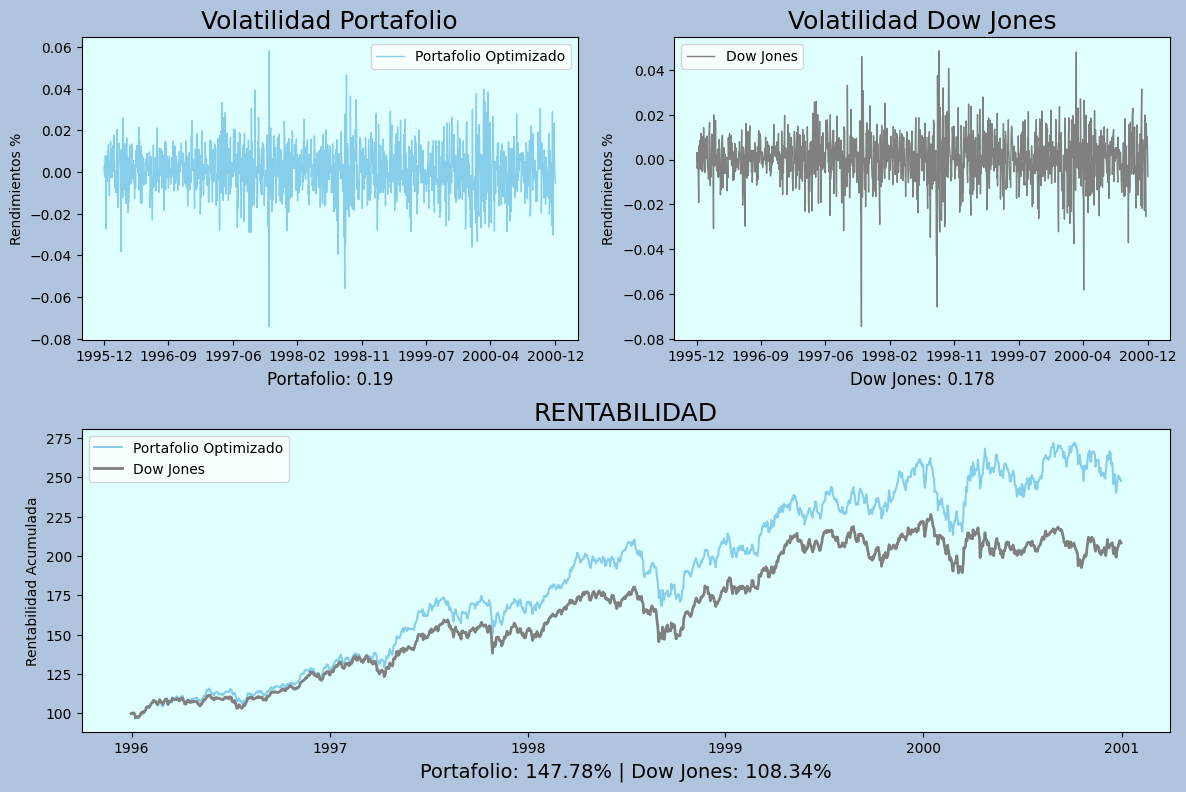

In [37]:
#Se muestran los gráficos que permiten realizar una parte de las comparaciones objetivo de este programa
graficos_de_evaluacion(data_graf_retorno, dj_graf_retorno, data_graf_volat, dj_graf_volat, rend_acu_portafolio, rend_acu_dow, volat_portafolio, volat_dow.iloc[0])

In [38]:
#Se muestran por pantalla los valores de los ratios de sharpe para el portafolio y para el Dow Jones, respectivamente
muestra_rs(rs_portafolio, rs_dow.iloc[0])

	El ratio sharpe resultante del portafolio es de: 0.647 puntos
	El ratio sharpe resultante del indice Dow Jones es de: 0.495 puntos
